In [1262]:
# Importing packages and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from pprint import pprint

test2 = pd.read_excel('D:\Kerja\Job Applications\Applications\CIMB Bank Berhad\Validation Recruitment Test\Validation Recruitment Test For Data Scientist Template.xls','Test2')

headers = test2.iloc[3,0:20]
test2_df = pd.DataFrame(test2.values[4:1433,0:20], columns = headers)
print(test2_df.head(5))

3 Country Name Country Code  \
0     Malaysia          MYS   
1     Malaysia          MYS   
2     Malaysia          MYS   
3     Malaysia          MYS   
4     Malaysia          MYS   

3                                        Description              Features  \
0  Unemployment, male (% of male labor force) (na...  SL.UEM.TOTL.MA.NE.ZS   
1  Unemployment, female (% of female labor force)...     SL.UEM.TOTL.FE.ZS   
2  Unemployment, female (% of female labor force)...  SL.UEM.TOTL.FE.NE.ZS   
3  Share of youth not in education, employment or...        SL.UEM.NEET.ZS   
4  Share of youth not in education, employment or...     SL.UEM.NEET.MA.ZS   

3 1960.0 2005.0 2006.0 2007.0 2008.0 2009.0 2010.0 2011.0 2012.0 2013.0  \
0    NaN   3.44    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN  3.705  3.391  3.445  3.673  3.794  3.433  3.314  3.162  3.436   
2    NaN   3.71    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN    NaN    NaN    NaN    NaN    NaN 

In [1205]:
print(test2_df['Country Name'].unique)

<bound method Series.unique of 0       Malaysia
1       Malaysia
2       Malaysia
3       Malaysia
4       Malaysia
          ...   
1424    Malaysia
1425    Malaysia
1426    Malaysia
1427    Malaysia
1428    Malaysia
Name: Country Name, Length: 1429, dtype: object>


In [1206]:
print(test2_df['Country Code'].unique)

<bound method Series.unique of 0       MYS
1       MYS
2       MYS
3       MYS
4       MYS
       ... 
1424    MYS
1425    MYS
1426    MYS
1427    MYS
1428    MYS
Name: Country Code, Length: 1429, dtype: object>


In [1207]:
# Since all observations are in the same country, both Country Name and Country Code columns will be dropped. Features column also will be dropped

test2_df = test2_df.drop(columns = ['Country Name','Country Code','Features'])
print(test2_df.head(5))

3                                        Description 1960.0 2005.0 2006.0  \
0  Unemployment, male (% of male labor force) (na...    NaN   3.44    NaN   
1  Unemployment, female (% of female labor force)...    NaN  3.705  3.391   
2  Unemployment, female (% of female labor force)...    NaN   3.71    NaN   
3  Share of youth not in education, employment or...    NaN    NaN    NaN   
4  Share of youth not in education, employment or...    NaN    NaN    NaN   

3 2007.0 2008.0 2009.0 2010.0 2011.0 2012.0 2013.0 2014.0 2015.0 2016.0  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   2.67   2.92   3.13   
1  3.445  3.673  3.794  3.433  3.314  3.162  3.436  3.222  3.392  3.929   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN   3.22   3.39   3.92   
3    NaN    NaN    NaN    NaN  14.37  13.95  13.65  12.77    NaN  11.69   
4    NaN    NaN    NaN    NaN   9.68   9.56   9.14   8.62    NaN   8.42   

3 2017.0 2018.0 2019.0  
0    NaN   3.09    NaN  
1  3.927  3.826   3.74  
2    NaN   

In [1308]:
# Transpose the dataset

test2_df_t = test2_df.set_index('Description').T.rename_axis('Year')

In [1307]:
# Finding the null values in each column

print(test2_df_t.isnull().sum().sort_values(ascending = False))

Description
Coverage of unemployment benefits and ALMP in 4th quintile (% of population)    16
Informal employment, female (% of total non-agricultural employment)            16
Net financial flows, IDA (NFL, current US$)                                     16
Net financial flows, multilateral (NFL, current US$)                            16
Female share of employment in senior and middle management (%)                  16
                                                                                ..
Manufacturing, value added (current US$)                                         1
Manufacturing, value added (current LCU)                                         1
Manufacturing, value added (% of GDP)                                            1
Industry (including construction), value added (current US$)                     1
Domestic credit to private sector (% of GDP)                                     1
Length: 1429, dtype: int64


In [1210]:
# Finding the percentage of missing values in each column

a = test2_df_t.isnull().sum() / len(test2_df_t) * 100
print(a)

Description
Unemployment, male (% of male labor force) (national estimate)                                                  68.75
Unemployment, female (% of female labor force) (modeled ILO estimate)                                            6.25
Unemployment, female (% of female labor force) (national estimate)                                              68.75
Share of youth not in education, employment or training, total (% of youth population)                          56.25
Share of youth not in education, employment or training, male (% of male youth population)                      56.25
                                                                                                                ...  
People using at least basic sanitation services, urban (% of urban population)                                  18.75
People using at least basic sanitation services, rural (% of rural population)                                  18.75
ARI treatment (% of children under 5 taken t

In [1211]:
# Finding the number of variables that contains more than 70% of their data as missing values 

print(len(a[a > 70]))

438


In [1309]:
# There are many variables that have many missing values with some of them contains no values at all
# Therefore, in order to reduce the dimensions and computational/training time of a dataset, some of the variables will be dropped
# Saving column names in a variable

variable = test2_df_t.columns

# New variable to store variables having missing values less than a threshold of 70%

variables = []

for i in range(test2_df_t.columns.shape[0]):
    if a[i] <= 70:  # Setting the threshold as 70%
        variables.append(variable[i])

In [1313]:
# Creating a new dataframe according to the above variables

new_test2_df_t = test2_df_t[variables]
print(new_test2_df_t.shape)

(19, 991)


In [1214]:
# Let's verify the difference between the shape of new and previous data

new_test2_df_t.shape, test2_df_t.shape

((16, 991), (16, 1429))

In [1215]:
# Let’s verify the percentage of missing values in each variable of the new_test2_df_t

print("Missing Values Percentage (%)")
print(new_test2_df_t.isnull().sum().sort_values(ascending = False) / len(new_test2_df_t) * 100)

Missing Values Percentage (%)
Description
Unemployment, male (% of male labor force) (national estimate)         68.75
Persistence to last grade of primary, female (% of cohort)             68.75
Poverty headcount ratio at $5.50 a day (2011 PPP) (% of population)    68.75
Poverty gap at $5.50 a day (2011 PPP) (%)                              68.75
Employment to population ratio, 15+, female (%) (national estimate)    68.75
                                                                       ...  
Population ages 50-54, female (% of female population)                  6.25
Population ages 50-54, male (% of male population)                      6.25
Population ages 55-59, female (% of female population)                  6.25
Population ages 55-59, male (% of male population)                      6.25
Death rate, crude (per 1,000 people)                                    6.25
Length: 991, dtype: float64


In [1216]:
# There are a minimum of 5 values out of 16 in each variable 

# Subsetting features and target variable into X and y respectively
# Since there is no value of the target variable in 1960 and 2019, the values in both rows will be dropped 

X = new_test2_df_t[new_test2_df_t.columns.difference(['Bank nonperforming loans to total gross loans (%)'])]
X = X.reset_index()
X = X.drop([0, 15])

y = new_test2_df_t['Bank nonperforming loans to total gross loans (%)']
y = y.reset_index(drop = True)
y = y.drop([0, 15])

In [1217]:
# Checking on features

print(X)

Description    Year  \
1            2005.0   
2            2006.0   
3            2007.0   
4            2008.0   
5            2009.0   
6            2010.0   
7            2011.0   
8            2012.0   
9            2013.0   
10           2014.0   
11           2015.0   
12           2016.0   
13           2017.0   
14           2018.0   

Description Access to clean fuels and technologies for cooking (% of population)  \
1                                                        96.03                     
2                                                        96.32                     
3                                                        96.34                     
4                                                        96.46                     
5                                                        96.43                     
6                                                        96.47                     
7                                                        96.56    

In [1218]:
# Checking on target variable

print(y)

1      9.39024
2     8.495599
3     6.498811
4     4.808181
5     3.626565
6     3.354027
7      2.68139
8     2.015843
9     1.849147
10    1.645785
11    1.601391
12    1.611897
13    1.545311
14    1.456309
Name: Bank nonperforming loans to total gross loans (%), dtype: object


In [1219]:
# Check on data types of each features

print(X.dtypes)

Description
Year                                                                                 float64
Access to clean fuels and technologies for cooking (% of population)                  object
Access to electricity (% of population)                                               object
Access to electricity, rural (% of rural population)                                  object
Access to electricity, urban (% of urban population)                                  object
                                                                                      ...   
Vulnerable employment, total (% of total employment) (modeled ILO estimate)           object
Wage and salaried workers, female (% of female employment) (modeled ILO estimate)     object
Wage and salaried workers, male (% of male employment) (modeled ILO estimate)         object
Wage and salaried workers, total (% of total employment) (modeled ILO estimate)       object
Women's share of population ages 15+ living with HIV (%)  

In [1220]:
# Coverting each feature data type to their appropriate data types

X['Year'] = X['Year'].astype('int64')

for col in X:
    if X[col].dtypes == 'object':
        X[col] = X[col].astype('float64')

# Verify the changes of data types on each feature

print(X.dtypes)

Description
Year                                                                                   int64
Access to clean fuels and technologies for cooking (% of population)                 float64
Access to electricity (% of population)                                              float64
Access to electricity, rural (% of rural population)                                 float64
Access to electricity, urban (% of urban population)                                 float64
                                                                                      ...   
Vulnerable employment, total (% of total employment) (modeled ILO estimate)          float64
Wage and salaried workers, female (% of female employment) (modeled ILO estimate)    float64
Wage and salaried workers, male (% of male employment) (modeled ILO estimate)        float64
Wage and salaried workers, total (% of total employment) (modeled ILO estimate)      float64
Women's share of population ages 15+ living with HIV (%)  

In [1221]:
# Before deciding on which technique to use in filling the missing values, lets find out if there is any outlier in the features
# Discover outliers with mathematical function, Z-score
# In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers

z = np.abs(stats.zscore(X[X.columns.difference(['Year'])]))
threshold = 3
print(np.where(z > 3))

(array([ 0,  0,  2,  2,  4,  4,  4,  4,  4,  4,  4,  5,  6, 13, 13, 13],
      dtype=int64), array([548, 762, 852, 876,  67, 274, 279, 297, 362, 399, 488, 577, 570,
       134, 768, 773], dtype=int64))


In [1222]:
# The first array contains the list of row numbers and second array contains the list of respective column numbers
# Checking an example of outlier in X

print(z[0][548])

3.184934740211772


In [1314]:
# Based on the Z-score above, there are a lot of outliers in X
# Therefore, the filling of missing values by using mean imputation is not a good idea

# Fill missing X values with interpolation

for col in X:
    X[col] = X[col].fillna(X[col].median())

print(X.isnull().sum())

Description
Year                                                                                 0
Access to clean fuels and technologies for cooking (% of population)                 0
Access to electricity (% of population)                                              0
Access to electricity, rural (% of rural population)                                 0
Access to electricity, urban (% of urban population)                                 0
                                                                                    ..
Vulnerable employment, total (% of total employment) (modeled ILO estimate)          0
Wage and salaried workers, female (% of female employment) (modeled ILO estimate)    0
Wage and salaried workers, male (% of male employment) (modeled ILO estimate)        0
Wage and salaried workers, total (% of total employment) (modeled ILO estimate)      0
Women's share of population ages 15+ living with HIV (%)                             0
Length: 991, dtype: int64


In [1224]:
# Check on data type of target variable

print(y.dtypes)

object


In [1225]:
# Converting data type of target variable from object to float

y = y.astype('float64')

# Verify the change of data type on the target variable

print(y.dtypes)

float64


In [1226]:
# Define feature selection

fs = SelectKBest(score_func = f_regression, k = 400)
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(14, 400)


C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:294: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) -
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:306: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [1227]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.1, random_state = 1111)

In [1228]:
print('Training Features (X_train) Shape:', X_train.shape)
print('Training Target Variable (y_train) Shape:', y_train.shape)
print('Testing Features (X_test) Shape:', X_test.shape)
print('Testing Target Variable (y_test) Shape:', y_test.shape)

Training Features (X_train) Shape: (12, 400)
Training Target Variable (y_train) Shape: (12,)
Testing Features (X_test) Shape: (2, 400)
Testing Target Variable (y_test) Shape: (2,)


In [1229]:
# Create a Random Forest Regression model

rfr = RandomForestRegressor(random_state = 1111)
pprint(rfr.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1111,
 'verbose': 0,
 'warm_start': False}


In [1230]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 40)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 110, num = 20)]
max_depth.append(None)
min_samples_split = range(2, 30)
min_samples_leaf = [1, 2, 4, 8, 12]

param_dist = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf}
pprint(param_dist)

{'max_depth': [5,
               10,
               16,
               21,
               27,
               32,
               38,
               43,
               49,
               54,
               60,
               65,
               71,
               76,
               82,
               87,
               93,
               98,
               104,
               110,
               None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 12],
 'min_samples_split': range(2, 30),
 'n_estimators': [5,
                  10,
                  15,
                  20,
                  25,
                  30,
                  35,
                  40,
                  45,
                  50,
                  55,
                  60,
                  65,
                  70,
                  75,
                  80,
                  85,
                  90,
                  95,
                  100,
                  105,
                  110,
 

In [1231]:
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = param_dist, n_iter = 100, n_jobs = -1, scoring = 'neg_mean_absolute_error', cv = 5, random_state = 1111, return_train_score = True, verbose = 0)

rfr_random.fit(X_train, y_train)
rfr_random.best_params_

{'n_estimators': 40,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 82}

In [1232]:
rfr_random.cv_results_

{'mean_fit_time': array([0.16056962, 0.30737753, 0.05026522, 0.20465269, 0.03829756,
        0.02174187, 0.04308414, 0.13982592, 0.21921344, 0.3069788 ,
        0.2902236 , 0.12107601, 0.15219278, 0.13404136, 0.14341621,
        0.25132761, 0.16376181, 0.18191004, 0.14640832, 0.33350763,
        0.15917411, 0.16017175, 0.15598288, 0.1180841 , 0.1870996 ,
        0.20385466, 0.14481258, 0.18231215, 0.21263113, 0.20445309,
        0.21701951, 0.07340369, 0.14900136, 0.06083722, 0.1749341 ,
        0.14182062, 0.04926829, 0.27646055, 0.05704732, 0.06901507,
        0.23756447, 0.21163392, 0.31236448, 0.28882732, 0.32951832,
        0.09793801, 0.17872186, 0.21143456, 0.12167416, 0.30777669,
        0.20385265, 0.06941428, 0.07001257, 0.31415935, 0.2810462 ,
        0.06542506, 0.07559762, 0.17732663, 0.16456017, 0.21901422,
        0.07978659, 0.12047753, 0.07779169, 0.29201894, 0.12805986,
        0.06282959, 0.27227173, 0.2557158 , 0.19408083, 0.07699399,
        0.14581008, 0.05226007,

In [1233]:
# Defining the evaluation function

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [1234]:
# Evaluate the default model

default_model = RandomForestRegressor(n_estimators = 10, random_state = 1111)
default_model.fit(X_train, y_train)
default_accuracy = evaluate(default_model, X_test, y_test)

Model Performance
Average Error: 0.0646 degrees.
Accuracy = 95.98%.


In [1235]:
# Evaluate the best random search model

best_random = rfr_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.1185 degrees.
Accuracy = 92.63%.


In [1268]:
print('From default model accuracy, improvement of {:0.2f}%.'.format( 100 * (random_accuracy - default_accuracy) / default_accuracy))

From default model accuracy, improvement of -3.49%.


In [1269]:
# The accuracy of random search model is becoming worse. Can we still improve more on the result from the random search model? 
# To find out, we will perform grid search building on the result from the random search
# We will test a range of hyperparameters around the best values returned by random search

param_dist_2 = {'n_estimators':[20,30,40,50,60], 'min_samples_split':[1,2,3,4], 'min_samples_leaf':[1,2,3,4], 'max_features':['auto'], 'max_depth':[70,80,90]}

rf = RandomForestRegressor(random_state = 1111)
first_grid_search = GridSearchCV(estimator = rf, param_grid = param_dist_2, cv = 5, n_jobs = -1, verbose = 2, return_train_score=True)
first_grid_search.fit(X_train, y_train)
first_grid_search.best_params_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
   0.81496435   0.6913368    0.75255345   0.75527008   0.74210598
   0.74943088   0.71740544   0.71719851   0.75955198   0.68058636
   0.15635084   0.26855787   0.39127789   0.49254606   0.37167394
          nan          nan          nan          nan          nan
   0.25924824   0.25114626   0.34801386   0.44190434   0.37973112
   0.25924824   0.25114626   0.34801386   0.44190434   0.37973112
   0.25924824   0.25114626   0.34801386   0.44190434   0.37973112
          nan          nan          nan          nan          nan
  -4.55816356  -3.92980304  -3.22835854  -3.00527263  -2.79541057
  -4.55816356  -3.92980304  -3.22835854  -3.00527263  -2.79541057
  -4.55816356  -3.92980304  -3.22835854  -3.00527263  -2.79541057
          nan          nan          nan          nan          nan


{'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 20}

In [1270]:
# Evaluate the best model from the first grid search

first_grid = first_grid_search.best_estimator_
first_grid_accuracy = evaluate(first_grid, X_test, y_test)

Model Performance
Average Error: 0.0561 degrees.
Accuracy = 96.50%.


In [1271]:
print('From default model accuracy, improvement of {:0.2f}%.'.format( 100 * (first_grid_accuracy - default_accuracy) / default_accuracy))

From default model accuracy, improvement of 0.53%.


In [1272]:
# Another round of grid search
# Number of trees (n_estimators) is varied in this model

param_dist_3 = {'n_estimators':[20,21,22,23,24,25,26], 'min_samples_split':[2], 'min_samples_leaf':[1], 'max_features':['auto'], 'max_depth':[70]}

rf_2 = RandomForestRegressor(random_state = 1111)
second_grid_search = GridSearchCV(estimator = rf, param_grid = param_dist_3, cv = 5, n_jobs = -1, verbose = 2, return_train_score=True)
second_grid_search.fit(X_train, y_train)
second_grid_search.best_params_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


{'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 26}

In [1273]:
# Evaluate the best model from the second grid search

second_grid = second_grid_search.best_estimator_
second_grid_accuracy = evaluate(second_grid, X_test, y_test)

Model Performance
Average Error: 0.0597 degrees.
Accuracy = 96.28%.


In [1274]:
print('From default model accuracy, improvement of {:0.2f}%.'.format( 100 * (second_grid_accuracy - default_accuracy) / default_accuracy))

From default model accuracy, improvement of 0.31%.


In [1275]:
# Final model
# The first_grid model is the best model
# We will use first_grid model as our final model

final_model = first_grid

print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')
grid_final_accuracy = evaluate(final_model, X_test, y_test)

Final Model Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 70,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1111,
 'verbose': 0,
 'warm_start': False}


Model Performance
Average Error: 0.0561 degrees.
Accuracy = 96.50%.


In [1276]:
# Comparison between these 3 models (Default, RandomizedSearchCV & GridSearchCV) in terms of accuracy, mean error & run time
# Evaluate run time and prediction accuracy

def evaluate_model(model, X_train, y_train, X_test, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = X_train.shape[1]
    
    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(X_train, y_train)
        predictions.append(model.predict(X_test))
    
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)
    
    # Calculate performance metrics
    errors = abs(predictions - y_test)
    mean_error = np.mean(errors)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # Return results in a dictionary
    results = {'Run time': run_time, 'Mean error': mean_error, 'Accuracy': accuracy, 'n_trees': n_trees, 'n_features': n_features}
    
    return results

In [1277]:
default_model_result = evaluate_model(default_model, X_train, y_train, X_test, y_test)
default_model_result['Model'] = 'Default Random Forest Regressor'
print(default_model_result)

{'Run time': 0.011771655082702637, 'Mean error': 0.0646318865960861, 'Accuracy': 95.98481212365111, 'n_trees': 10, 'n_features': 400, 'Model': 'Default Random Forest Regressor'}


In [1278]:
best_random_result = evaluate_model(best_random, X_train, y_train, X_test, y_test)
best_random_result['Model'] = 'RandomizedSearchCV'
print(best_random_result)

{'Run time': 0.04278559684753418, 'Mean error': 0.1184646740740738, 'Accuracy': 92.63023237512174, 'n_trees': 40, 'n_features': 400, 'Model': 'RandomizedSearchCV'}


In [1282]:
second_grid_result = evaluate_model(second_grid, X_train, y_train, X_test, y_test)
second_grid_result['Model'] = 'SecondGridSearchCV'
print(second_grid_result)

{'Run time': 0.02842249870300293, 'Mean error': 0.059681117865254096, 'Accuracy': 96.27816013072888, 'n_trees': 26, 'n_features': 400, 'Model': 'SecondGridSearchCV'}


In [1283]:
final_model_result = evaluate_model(final_model, X_train, y_train, X_test, y_test)
final_model_result['Model'] = 'Final model - FirstGridSearchCV'
print(final_model_result)

{'Run time': 0.0226395845413208, 'Mean error': 0.05612391383757376, 'Accuracy': 96.49762644035867, 'n_trees': 20, 'n_features': 400, 'Model': 'Final model - FirstGridSearchCV'}


In [1284]:
comparison = {'Model':[default_model_result['Model']], 'Accuracy':[round(default_model_result['Accuracy'], 3)], 'Mean error':[round(default_model_result['Mean error'], 3)], 'Run time':[round(default_model_result['Run time'], 3)], 'n_features':[default_model_result['n_features']], 'n_trees':[default_model_result['n_trees']]}

for model in [best_random_result, second_grid_result, final_model_result]:
    comparison['Model'].append(model['Model'])
    comparison['Accuracy'].append(round(model['Accuracy'], 3))
    comparison['Mean error'].append(round(model['Mean error'], 3))
    comparison['Run time'].append(round(model['Run time'], 3))
    comparison['n_features'].append(model['n_features'])
    comparison['n_trees'].append(int(model['n_trees']))

In [1285]:
comparison = pd.DataFrame.from_dict(comparison, orient = 'columns')

In [1286]:
# Display the comparisons

display(comparison[['Model', 'Accuracy', 'Mean error', 'Run time', 'n_features', 'n_trees']].sort_values(ascending = False, by = ['Accuracy']))

,Model,Accuracy,Mean error,Run time,n_features,n_trees
3,Final model - FirstGridSearchCV,96.498,0.056,0.023,400,20
2,SecondGridSearchCV,96.278,0.060,0.028,400,26
0,Default Random Forest Regressor,95.985,0.065,0.012,400,10
1,RandomizedSearchCV,92.630,0.118,0.043,400,40


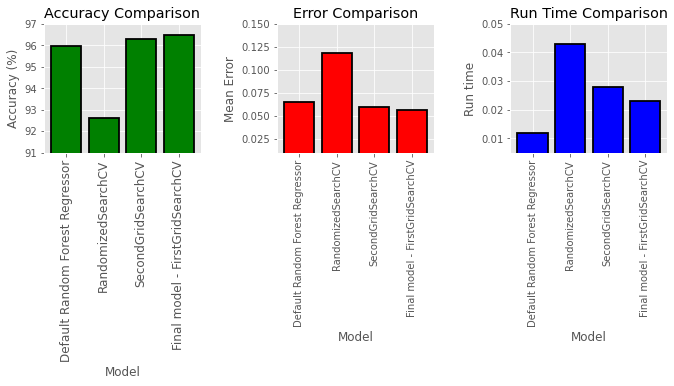

In [1288]:
%matplotlib inline

plt.style.use('ggplot')
xvalues = list(range(len(comparison)))
figure, axes = plt.subplots(1, 3, figsize=(10, 6))
plt.subplot(131)
plt.bar(xvalues, comparison['Accuracy'], color = 'g', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['Model'], rotation = 90, fontsize = 12)
plt.ylim(ymin = 91, ymax = 97)
plt.xlabel('Model'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy Comparison');

plt.subplot(132)
plt.bar(xvalues, comparison['Mean error'], color = 'r', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['Model'], rotation = 90)
plt.ylim(ymin = 0.01, ymax = 0.15)
plt.xlabel('Model'); plt.ylabel('Mean Error'); plt.title('Error Comparison');

plt.subplot(133)
plt.bar(xvalues, comparison['Run time'], color = 'b', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['Model'], rotation = 90)
plt.ylim(ymin = 0.005, ymax = 0.05)
plt.xlabel('Model'); plt.ylabel('Run time'); plt.title('Run Time Comparison');
figure.tight_layout(pad = 3)
plt.show()

In [1294]:
# We can see that the best model that achieves the highest accuracy & lowest mean error is the final_model (FirstGridSearchCV) model
# Whereas the model that achieve the lowest run time is the default_model (Default Random Forest Regressor) model
# Now that we have our final model which was generated from GridSearchCV, can we still search over only one parameter at one time to observe the effects of changing that parameter on training time, training set accuracy, and testing set accuracy

# First varying parameter is number of trees (n_estimators)

tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 301, 30)]}

# Create the grid search model and fit to the training data

tree_grid_search = GridSearchCV(estimator = final_model, param_grid = tree_grid, cv = 5, n_jobs = -1, verbose = 2, return_train_score=True)
tree_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=70, n_estimators=20,
                                             random_state=1111),
             n_jobs=-1,
             param_grid={'n_estimators': [1, 11, 21, 32, 42, 52, 63, 73, 83, 94,
                                          104, 114, 125, 135, 145, 156, 166,
                                          176, 187, 197, 207, 218, 228, 238,
                                          249, 259, 269, 280, 290, 301]},
             return_train_score=True, verbose=2)

In [1295]:
tree_grid_search.cv_results_

{'mean_fit_time': array([0.00299187, 0.02453589, 0.04009151, 0.0566483 , 0.07799096,
        0.09733939, 0.11668711, 0.13703327, 0.15119529, 0.18051705,
        0.22260447, 0.22759099, 0.24275036, 0.26469164, 0.27586179,
        0.30079503, 0.29560928, 0.3359014 , 0.38955755, 0.35764351,
        0.42625985, 0.44481015, 0.4458075 , 0.44022222, 0.48490305,
        0.50923781, 0.51980939, 0.51202817, 0.52599287, 0.53417001]),
 'std_fit_time': array([5.51978917e-07, 6.26248387e-03, 3.69911085e-03, 4.15555370e-03,
        4.34281173e-03, 9.49528839e-03, 8.17482194e-03, 9.76364010e-03,
        1.15208143e-02, 2.35756313e-02, 1.87160974e-02, 3.14839719e-02,
        2.08972493e-02, 2.57270243e-02, 1.39712972e-02, 2.52358938e-02,
        2.00323192e-02, 1.48515742e-02, 2.47731186e-02, 2.31209466e-02,
        2.46612735e-02, 2.84265339e-02, 2.05654544e-02, 4.12061250e-02,
        3.88801113e-02, 4.86370746e-02, 4.07390545e-02, 7.97084059e-02,
        1.14438351e-01, 1.11891921e-02]),
 'mean_scor

In [1301]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -2, ymax = 2)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

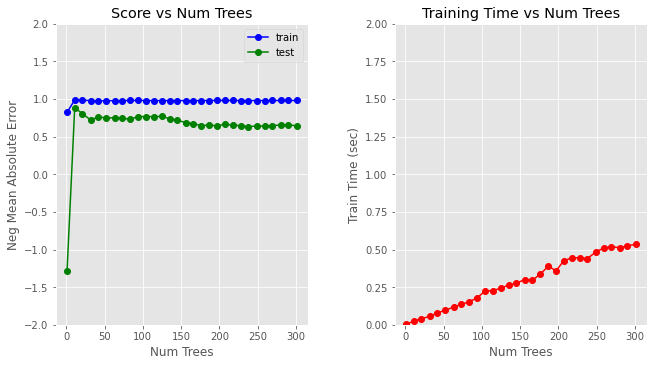

In [1302]:
plot_results(tree_grid_search)